# Problem Statement

For this task, you are given a set of longitudinal data (attached) of different lab measurements for patients diagnosed with chronic kidney disease (CKD). Furthermore, you are also given the information whether these patients progress in their CKD stage or not in the future. Using this dataset, you are required to come up with a solution to predict whether a patient will progress in CKD staging given the patient's past longitudinal information.

The following CSV files are provided:

**T_demo.csv**
id: patient id
race: patient’s race
gender: patient’s gender
age: patient’s age at baseline

**T_creatinine.csv**
id: patient id
value: patient’s serum creatinine value at the corresponding time (in mg/dl)
time: time of measurement (in days from baseline t=0)

**T_DBP.csv**
id: patient id
value: patient’s diastolic blood pressure at the corresponding time (in mmHg)
time: time of measurement (in days from baseline t=0)

**T_SBP.csv**
id: patient id
value: patient’s systolic blood pressure at the corresponding time (in mmHg)
time: time of measurement (in days from baseline t=0)

**T_HGB.csv**
id: patient id
value: patient’s Hemoglobin level at the corresponding time (in g/dl)
time: time of measurement (in days from baseline t=0)

**T_glucose.csv**
id: patient id
value: patient’s glucose level at the corresponding time (in mmol/l)
time: time of measurement (in days from baseline t=0)

**T_ldl.csv**
id: patient id
value: patient’s low-density lipoprotein (LDL-c) level at the corresponding time (in mg/dl)
time: time of measurement (in days from baseline t=0)

**T_meds.csv**
id: patient id
drug: the name of the drug being prescribed
daily_dosage: the dosage of the drug being prescribed (in mg)
start_day: the starting time of the prescription (in days from baseline t=0)
end_day: the end of the prescription (in days from baseline t=0)

**T_stage.csv**
id: patient id
Stage_Progress: indicator of whether or not the patient progress in the CKD stage (True=progress)


#Setup

In [168]:
#Import necessary modules and declare data sources from github
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn as sk
import seaborn as sns
from heatmap import heatmap, corrplot
from sklearn import svm, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots

import sktime as st
import category_encoders as ce
%matplotlib inline

dpb_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_DBP.csv'
hgb_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_HGB.csv'
spb_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_SBP.csv'
creatine_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_creatinine.csv'
demo_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_demo.csv'
glucose_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_glucose.csv'
ldl_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_ldl.csv'
meds_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_meds.csv'
stage_url = 'https://raw.githubusercontent.com/tartarsause/Holmusk_task/main/data/T_stage.csv'

#Data Exploration

In [162]:
#Create dataframes from github urls

dpb_df = pd.read_csv(dpb_url)
hgb_df = pd.read_csv(hgb_url)
spb_df = pd.read_csv(spb_url)
creatine_df = pd.read_csv(creatine_url)
demo_df = pd.read_csv(demo_url)
glucose_df = pd.read_csv(glucose_url)
ldl_df = pd.read_csv(ldl_url)
meds_df = pd.read_csv(meds_url)
stage_df = pd.read_csv(stage_url)

In [163]:
display(demo_df)
display(dpb_df)
display(hgb_df)
display(spb_df)
display(creatine_df)
display(glucose_df)
display(ldl_df)
display(meds_df)
display(stage_df)
display(stage_df.dtypes)

,id,race,gender,age
0,0,Unknown,Male,70
1,1,White,Female,71
2,2,White,Female,57
3,3,White,Male,74
4,4,White,Female,50
...,...,...,...,...
295,295,White,Female,79
296,296,White,Female,66
297,297,Unknown,Male,80
298,298,Asian,Female,72


,id,value,time
0,0,95.32,0
1,0,83.98,98
2,0,65.97,279
3,0,83.41,380
4,0,86.39,475
...,...,...,...
1816,299,70.91,210
1817,299,82.62,289
1818,299,90.39,372
1819,299,82.90,389


,id,value,time
0,0,13.51,0
1,0,13.39,107
2,0,12.84,286
3,0,13.32,382
4,0,13.53,688
...,...,...,...
2020,299,14.76,0
2021,299,14.74,531
2022,299,14.43,659
2023,299,14.90,1069


,id,value,time
0,0,134.11,0
1,0,133.75,98
2,0,125.08,279
3,0,136.75,380
4,0,130.50,475
...,...,...,...
1804,299,92.70,210
1805,299,125.80,289
1806,299,130.41,372
1807,299,141.68,389


,id,value,time
0,0,1.29,0
1,0,1.15,107
2,0,1.44,286
3,0,1.23,382
4,0,1.08,580
...,...,...,...
1434,298,1.32,308
1435,298,0.97,450
1436,299,1.12,0
1437,299,1.09,531


,id,value,time
0,0,6.24,0
1,0,7.20,107
2,0,7.01,286
3,0,6.89,382
4,0,5.62,580
...,...,...,...
1551,298,5.34,310
1552,298,5.98,452
1553,299,5.60,0
1554,299,6.14,411


,id,value,time
0,0,161.49,0
1,0,111.39,107
2,0,157.90,382
3,1,89.57,0
4,1,98.73,221
...,...,...,...
1256,298,76.59,310
1257,298,62.08,452
1258,299,66.45,0
1259,299,73.28,538


,id,drug,daily_dosage,start_day,end_day
0,0,atorvastatin,10.0,19,109
1,0,atorvastatin,10.0,117,207
2,0,losartan,100.0,19,289
3,0,losartan,100.0,403,493
4,0,losartan,100.0,587,677
...,...,...,...,...,...
2176,299,losartan,100.0,144,174
2177,299,losartan,100.0,461,491
2178,299,losartan,100.0,497,527
2179,299,losartan,100.0,529,559


,id,Stage_Progress
0,0,True
1,1,False
2,2,True
3,3,False
4,4,True
...,...,...
295,295,True
296,296,False
297,297,True
298,298,False


id                int64
Stage_Progress     bool
dtype: object

Findings from data:
*   Demo data contains nominal categorical data, i.e. there is no order to the data, which we should encode (race, gender)
*   7 tables contain time series data, with meds table containing both categorical and time series data
* Stages table contains boolean data type and its not evenly distributed(100 True, 200 False)



In [170]:
print(demo_df.describe())
print(dpb_df.describe())
print(hgb_df.describe())
print(stage_df['Stage_Progress'].value_counts())

               id         age
count  300.000000  300.000000
mean   149.500000   70.383333
std     86.746758    9.247058
min      0.000000   46.000000
25%     74.750000   64.000000
50%    149.500000   71.000000
75%    224.250000   78.000000
max    299.000000   86.000000
                id        value         time
count  1821.000000  1821.000000  1821.000000
mean    149.403624    79.518583   305.311917
std      87.045934    10.178676   221.674079
min       0.000000    44.950000     0.000000
25%      74.000000    72.830000    97.000000
50%     150.000000    79.050000   301.000000
75%     226.000000    86.170000   496.000000
max     299.000000   112.930000   699.000000
                id        value         time
count  2025.000000  2025.000000  2025.000000
mean    147.617284    13.825185   598.223704
std      87.979281     1.644946   425.010281
min       0.000000     8.820000     0.000000
25%      70.000000    12.670000   198.000000
50%     147.000000    13.920000   599.000000
75%     22

#Data Preprocessing

In [171]:
#Merging of demo and stage df
result_df = demo_df.merge(stage_df, how='left', on='id')

#Using one-hot encoding for categorical variables since we'll be standardizing later
encoder = ce.OneHotEncoder(cols=['race','gender'], return_df=True,use_cat_names=True)
result_encoded = encoder.fit_transform(result_df)

#NOTE: multicollinearity might be an issue, should use Variance Inflation Factor to determine if a column should be dropped
result_encoded

C:\Users\demma\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,id,race_Unknown,race_White,race_Black,race_Asian,race_Hispanic,gender_Male,gender_Female,age,Stage_Progress
0,0,1,0,0,0,0,1,0,70,True
1,1,0,1,0,0,0,0,1,71,False
2,2,0,1,0,0,0,0,1,57,True
3,3,0,1,0,0,0,1,0,74,False
4,4,0,1,0,0,0,0,1,50,True
...,...,...,...,...,...,...,...,...,...,...
295,295,0,1,0,0,0,0,1,79,True
296,296,0,1,0,0,0,0,1,66,False
297,297,1,0,0,0,0,1,0,80,True
298,298,0,0,0,1,0,0,1,72,False


#Quick classical model classification attempt

In [172]:
#Logistic regression classfication based on the current features
y = result_encoded.iloc[:,9]
x = result_encoded.iloc[:,1:9]

display(y)
display(x)

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(x, y)
print("Simple logistic regression score: ",LR.score(x,y))

0       True
1      False
2       True
3      False
4       True
       ...  
295     True
296    False
297     True
298    False
299    False
Name: Stage_Progress, Length: 300, dtype: bool

,race_Unknown,race_White,race_Black,race_Asian,race_Hispanic,gender_Male,gender_Female,age
0,1,0,0,0,0,1,0,70
1,0,1,0,0,0,0,1,71
2,0,1,0,0,0,0,1,57
3,0,1,0,0,0,1,0,74
4,0,1,0,0,0,0,1,50
...,...,...,...,...,...,...,...,...
295,0,1,0,0,0,0,1,79
296,0,1,0,0,0,0,1,66
297,1,0,0,0,0,1,0,80
298,0,0,0,1,0,0,1,72


Simple logistic regression score:  0.7


In [173]:
#Support Vector Machine classification
SVM = svm.LinearSVC(max_iter=-1)
SVM.fit(x,y)

SVM.score(x,y)

C:\Users\demma\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.6666666666666666

In [174]:
#Random Forest classification
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2)
RF.fit(x,y)

RF.score(x,y)

0.7533333333333333

#Time Series Data Primitive Extraction

In [175]:
#Group by ID and find mean test values for dpb, hgb, spb, creatine, glucose and ldl data and rename column name
dpb = dpb_df.groupby(["id"]).mean()
dpb = dpb.rename(columns = {'value':"avg_dpb"})
hgb = hgb_df.groupby(["id"]).mean()
hgb = hgb.rename(columns = {'value':"avg_hgb"})
spb = spb_df.groupby(['id']).mean()
spb = spb.rename(columns = {'value':"avg_spb"})
creatine = creatine_df.groupby(['id']).mean()
creatine = creatine.rename(columns = {'value':"avg_creatine"})
glucose = glucose_df.groupby(["id"]).mean()
glucose = glucose.rename(columns = {'value':"avg_glucose"})
ldl = ldl_df.groupby(["id"]).mean()
ldl = ldl.rename(columns = {'value':"avg_ldl"})

dpb.reset_index(inplace=True)
hgb.reset_index(inplace=True)
hgb.reset_index(inplace=True)
spb.reset_index(inplace=True)
creatine.reset_index(inplace=True)
glucose.reset_index(inplace=True)
ldl.reset_index(inplace=True)
dpb

,id,avg_dpb,time
0,0,83.173750,396.125000
1,1,80.455714,350.571429
2,2,89.217500,310.500000
3,3,74.857143,423.285714
4,4,97.385714,349.285714
...,...,...,...
295,295,83.420000,277.000000
296,296,88.365714,364.285714
297,297,70.895000,315.750000
298,298,76.475000,187.250000


In [178]:
#Concat grouped data to result table
merged_result_df = result_encoded
merged_result_df = pd.merge(merged_result_df,dpb[['id','avg_dpb']],on='id', how='left')
merged_result_df = pd.merge(merged_result_df,hgb[['id','avg_hgb']],on='id', how='left')
merged_result_df = pd.merge(merged_result_df,spb[['id','avg_spb']],on='id', how='left')
merged_result_df = pd.merge(merged_result_df,creatine[['id','avg_creatine']],on='id', how='left')
merged_result_df = pd.merge(merged_result_df,glucose[['id','avg_glucose']],on='id', how='left')
merged_result_df = pd.merge(merged_result_df,ldl[['id','avg_ldl']],on='id', how='left')

#re-ordering of merged_result_df columns
# cols = merged_result_df.columns.tolist()
merged_result_df = merged_result_df[[
 'race_Unknown',
 'race_White',
 'race_Black',
 'race_Asian',
 'race_Hispanic',
 'gender_Male',
 'gender_Female',
 'age',
 'avg_dpb',
 'avg_hgb',
 'avg_spb',
 'avg_creatine',
 'avg_glucose',
 'avg_ldl',
 'Stage_Progress']]

y = merged_result_df.iloc[:,14]
x = merged_result_df.iloc[:,:14]

#Should stage_progress be converted to int?
merged_result_df['Stage_Progress'] = merged_result_df['Stage_Progress'].astype(int)

# display(merged_result_df)

#Split data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=17)

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

#numerical features
num_cols = ['age','avg_dpb','avg_hgb','avg_spb','avg_creatine','avg_glucose','avg_ldl']

#Standardizing numerical features
for i in num_cols:
  scale=StandardScaler().fit(X_train_stand[[i]])

  X_train_stand[i] = scale.transform(X_train_stand[[i]])

  X_test_stand[i] = scale.transform(X_test_stand[[i]])

#Normalize values since we'll be working with euclidean distance based algorithms
#Should standardize numerical columns and use one-hot encoding for cat variables instead so that standardization does not affect columns

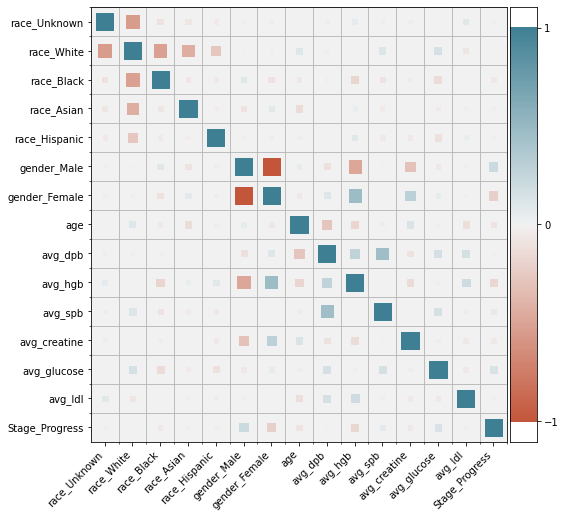

In [179]:
#Collinearity matrix
plt.figure(figsize=(8, 8))
corrplot(merged_result_df.corr(), size_scale=300);

#Second Attempt at classicial model classification

In [180]:
#Logistic Regression classification
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=1000).fit(X_train_stand, y_train)
print("Simple logistic regression score: ",LR.score(X_test_stand,y_test))

Simple logistic regression score:  0.7


In [181]:
#Support Vector Machine classification
SVM = svm.LinearSVC(max_iter=-1)
SVM.fit(X_train_stand,y_train)

SVM.score(X_test_stand,y_test)

C:\Users\demma\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7333333333333333

In [182]:
#Random Forest classification
RF = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=2)
RF.fit(x,y)

RF.score(x,y)

0.86

In [183]:
#Random Forest classification with standardized data
RF = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=2)
RF.fit(X_train_stand,y_train)

RF.score(X_test_stand,y_test)

0.7666666666666667

In [198]:
#Prediction Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

actual = y_test
predicted = RF.predict(X_test_stand)
# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 2  6]
 [ 1 21]]
Outcome values : 
 2 6 1 21
Classification report : 
               precision    recall  f1-score   support

           1       0.67      0.25      0.36         8
           0       0.78      0.95      0.86        22

    accuracy                           0.77        30
   macro avg       0.72      0.60      0.61        30
weighted avg       0.75      0.77      0.73        30



KNN with Dynamic Time Warping would be a good classifier for the time series data

#Time Series Data Preprocessing

In [184]:
dpb_comb = dpb_df.groupby(['id'], as_index = False).agg({'value': lambda x: ' '.join(x.astype(str))})
hgb_comb = hgb_df.groupby(['id'], as_index = False).agg({'value': lambda x: ' '.join(x.astype(str))})
spb_comb = spb_df.groupby(['id'], as_index = False).agg({'value': lambda x: ' '.join(x.astype(str))})
creatine_comb = creatine_df.groupby(['id'], as_index = False).agg({'value': lambda x: ' '.join(x.astype(str))})
glucose_comb = glucose_df.groupby(['id'], as_index = False).agg({'value': lambda x: ' '.join(x.astype(str))})
ldl_comb = ldl_df.groupby(['id'], as_index = False).agg({'value': lambda x: ' '.join(x.astype(str))})
# ldl_comb